In [ ]:
import matplotlib.pyplot as plt
import time 
import numpy as np
import pandas as pd
import scipy.io
from sktime.libs.vmdpy import VMD
from pymultifracs.wavelet import wavelet_analysis
from pymultifracs.mf_analysis import mfa
from pymultifracs.utils import build_q_log
from scipy.signal import welch
from sktime.transformations.series.vmd import VmdTransformer
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import periodogram
import numpy as np
# Core libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import seaborn as sns
from pandas import Series

# Signal processing
from scipy import signal
from scipy.signal import periodogram
from scipy.stats import entropy, kurtosis, skew
from scipy.signal import butter
import scipy.signal as sp_signal  # rename to avoid collision


# Decomposition methods
from PyEMD import EMD, EEMD, CEEMDAN
from vmdpy import VMD
import ewtpy

# Optional: your custom transformer (you must have this file)
from sktime.transformations.series.vmd import VmdTransformer
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import torch
import numpy as np
import sys
import os
import time

# Go up two levels from notebooks/vmd/ to reach src/mvmd/
mvmd_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'src', 'mvmd'))
sys.path.append(mvmd_path)

# Now import mvmd_optimized
from mvmd_original import mvmd 
#from mvmd_optimized import mvmd 

## 1. Data exploration:

In [2]:
# Load the .mat file
data = scipy.io.loadmat('../../data/data.mat')
# List keys
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'data', 'sfreq'])


In [3]:
for key in data:
    print(f"{key}: type={type(data[key])}, shape={getattr(data[key], 'shape', 'N/A')}")


__header__: type=<class 'bytes'>, shape=N/A
__version__: type=<class 'str'>, shape=N/A
__globals__: type=<class 'list'>, shape=N/A
data: type=<class 'numpy.ndarray'>, shape=(548240, 2)
sfreq: type=<class 'numpy.ndarray'>, shape=(1, 1)


In [4]:
signal = data['data']  # shape = (n_samples, n_channels)
sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

In [5]:
print("Signal shape:", signal.shape)
print("Signal dtype:", signal.dtype)
print("Signal size in bytes:", signal.nbytes)
print("Signal size in MB:", signal.nbytes / (1024**2))

Signal shape: (548240, 2)
Signal dtype: float64
Signal size in bytes: 8771840
Signal size in MB: 8.365478515625


<function matplotlib.pyplot.show(close=None, block=None)>

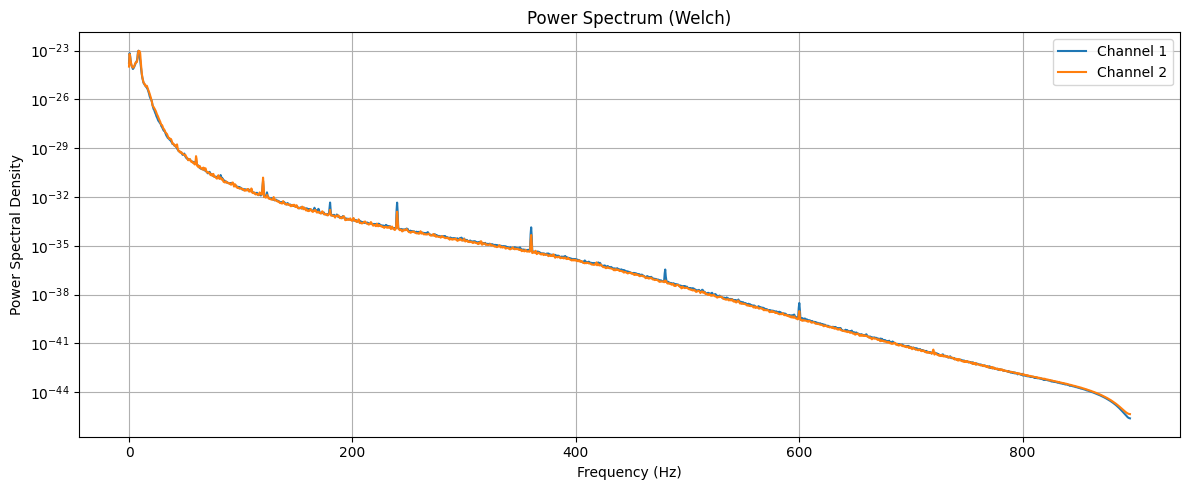

In [6]:
#sfreq = data.get('sfreq', 1).squeeze()  # sampling frequency, set to 1 if missing

# Choose window length
nperseg = int(sfreq * 2)  # 2-second segments

# Channel 1
f1, Pxx1 = welch(signal[:, 0], fs=sfreq, nperseg=nperseg)
# Channel 2
f2, Pxx2 = welch(signal[:, 1], fs=sfreq, nperseg=nperseg)

plt.figure(figsize=(12, 5))
plt.semilogy(f1, Pxx1, label='Channel 1')
plt.semilogy(f2, Pxx2, label='Channel 2')
plt.title("Power Spectrum (Welch)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show


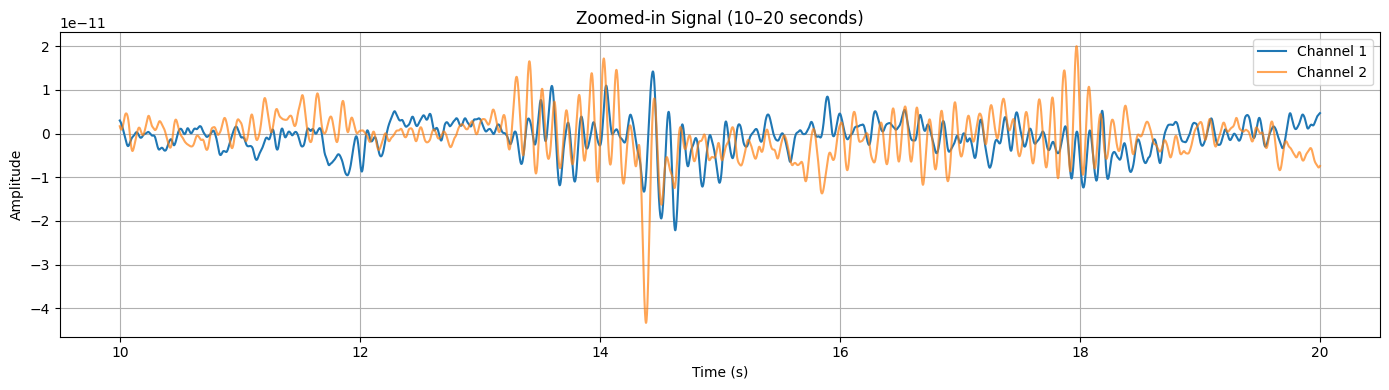

In [7]:
n_samples = signal.shape[0]
time = np.arange(n_samples) / sfreq  # time axis in seconds

zoom_start = int(10 * sfreq)
zoom_end = int(20 * sfreq)

plt.figure(figsize=(14, 4))
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 0], label="Channel 1")
plt.plot(time[zoom_start:zoom_end], signal[zoom_start:zoom_end, 1], label="Channel 2", alpha=0.7)
plt.title("Zoomed-in Signal (10–20 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## 2. Signal Decomposition (EMD, VMD, MVMD):

In [8]:
def extract_features_from_mode(mode, Fs):
    """Compute features from a single mode."""
    features = []
    labels = []

    mode = np.asarray(mode).flatten()
    N = len(mode)

    # AM (mean absolute value)
    AM = np.mean(np.abs(mode))
    features.append(AM)
    labels.append("AM")

    # BM (band energy)
    BM = np.sum(mode ** 2)
    features.append(BM)
    labels.append("BM")

    # Shannon entropy
    hist, bin_edges = np.histogram(mode, bins=100, density=True)
    ent_val = entropy(hist + 1e-12)
    features.append(ent_val)
    labels.append("ent")

    # Spectral features
    f, Pxx = periodogram(mode, fs=Fs)
    Pxx = np.nan_to_num(Pxx)
    f = np.nan_to_num(f)

    # Spectral centroid
    if np.sum(Pxx) > 0:
        centroid = np.sum(f * Pxx) / np.sum(Pxx)
    else:
        centroid = 0.0
    features.append(centroid)
    labels.append("Cent")

    # Spectral power
    power = np.sum(Pxx)
    features.append(power)
    labels.append("Pfreq")

    # Peak frequency
    if len(Pxx) > 0:
        peak_freq = f[np.argmax(Pxx)]
    else:
        peak_freq = 0.0
    features.append(peak_freq)
    labels.append("Ppeak")

    # Skewness
    skewness = skew(mode)
    features.append(skewness)
    labels.append("skew")

    # Kurtosis
    kurt = kurtosis(mode)
    features.append(kurt)
    labels.append("kurt")

    # Hjorth mobility
    dx = np.diff(mode)
    var_mode = np.var(mode)
    var_dx = np.var(dx)
    Hmob = np.sqrt(var_dx / var_mode) if var_mode > 0 else 0.0
    features.append(Hmob)
    labels.append("Hmob")

    # Hjorth complexity
    ddx = np.diff(dx)
    var_ddx = np.var(ddx)
    var_dx = np.var(dx)
    Hcomp = np.sqrt(var_ddx / var_dx) / Hmob if var_dx > 0 and Hmob > 0 else 0.0
    features.append(Hcomp)
    labels.append("Hcomp")

    return features, labels

def plot_original_and_modes(x, sfreq, modes, method, ch, output_dir):
    """Plot original signal, spectrum, and decomposed modes"""
    t = np.linspace(0, len(x)/sfreq, len(x))
    method_fig_dir = os.path.join(output_dir, method, "figures")
    os.makedirs(method_fig_dir, exist_ok=True)

    Nmode = modes.shape[0]
    ncols = 2
    nrows = 2 + int(np.ceil(Nmode / ncols))  # one row for original + spectrum, rest for modes

    plt.figure(figsize=(10, 2.5 * nrows))

    # Original signal
    plt.subplot(nrows, ncols, 1)
    plt.plot(t, x, color='k')
    plt.title(f'Original Signal - Ch{ch}')
    plt.xlabel('Time (s)')

    # Spectrum
    plt.subplot(nrows, ncols, 2)
    f_fft = np.fft.fft(x)
    f_fft = np.abs(f_fft[:len(f_fft)//2])
    f_freq = np.fft.fftfreq(len(x), 1/sfreq)[:len(x)//2]
    plt.plot(f_freq, f_fft, color='k')
    plt.title(f'Spectrum - Ch{ch}')
    plt.xlabel('Frequency (Hz)')

    # Modes
    for i in range(Nmode):
        plt.subplot(nrows, ncols, 3 + i)
        plt.plot(t, modes[i], color='k')
        plt.title(f'{method} Mode {i}')
        plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.savefig(os.path.join(method_fig_dir, f'channel_{ch}_{method}_overview.png'))
    plt.close()

def apply_all_decompositions(signal_in, Fs, Nmodes, methods=None, return_modes=False):
    if methods is None:
        methods = ['EMD', 'EEMD', 'CEEMDAN', 'EWT', 'VMD', 'MVMD']

    results = {}
    modes_out = {}

    for method in methods:
        try:
            start_time = time.time()  # ⏱️ Start timing

            if method == 'EMD':
                emd = EMD()
                IMFs = emd.emd(signal_in)

            elif method == 'EEMD':
                eemd = EEMD()
                eemd.trials = 100
                IMFs = eemd(signal_in, max_imf=Nmodes)

            elif method == 'CEEMDAN':
                ceemdan = CEEMDAN()
                IMFs = ceemdan(signal_in, max_imf=Nmodes)

            elif method == 'EWT':
                ewt, _, _ = ewtpy.EWT1D(signal_in, N=Nmodes)
                IMFs = ewt.T

            elif method == 'VMD':
                DC = 0
                alpha = 200
                tau = 0
                init = 1
                tol = 1e-7
                IMFs, _, _ = VMD(signal_in, alpha, tau, Nmodes, DC, init, tol)

            elif method == 'VMDtransformer':
                vmd_transformer = VmdTransformer(K=None, kMax=7, energy_loss_coefficient=0.0001)
                IMFs = vmd_transformer.fit_transform(Series(signal_in)).to_numpy().T
                if IMFs.ndim == 1:
                    IMFs = IMFs.reshape(1, -1)

            else:
                continue

            exec_time = time.time() - start_time  # ⏱️ Stop timing

            modes_out[method] = IMFs

            all_feats = []
            all_labels = []

            for idx, mode in enumerate(IMFs):
                mode = np.ravel(mode)  # 🩹 Ensure 1D shape

                feats, labels = extract_features_from_mode(mode, Fs)
                all_feats.extend(feats)
                all_labels.extend([f"{label}{idx}" for label in labels])

            # Add execution time + mode count
            all_feats.append(exec_time)
            all_labels.append("decTime")
            all_feats.append(len(IMFs))
            all_labels.append("n_modes")

            results[method] = {"labels": all_labels, "values": all_feats}

        except Exception as e:
            print(f"❌ Error processing {method}: {e}")
            continue

    return (results, modes_out) if return_modes else results


In [ ]:
# === Load signal === #
matfile = '../../data/data.mat'
data = scipy.io.loadmat(matfile)
signal_data = data['data']  # shape: (n_samples, n_channels)
sfreq = float(data.get('sfreq', np.array([[1]])).squeeze())

# === Optional preprocessing === #
amplification_factor = 1e9
signal_data = signal_data * amplification_factor
noise_level = 0.001 * np.std(signal_data)
signal_data += np.random.normal(0, noise_level, signal_data.shape)

# === Parameters === #
Nmodes = 2
output_dir = 'features_output'
methods_to_use = ["EMD", "VMDtransformer"]  # MVMD handled separately
n_channels = signal_data.shape[1]

os.makedirs(output_dir, exist_ok=True)

# === 1. MVMD on full multichannel signal === #
print("\n🚀 Running MVMD on all channels together")
multi_signal = signal_data.T  # shape: (C, T)
x_tensor = torch.tensor(multi_signal, dtype=torch.float32)
print(type(x_tensor))
x_tensor.shape
u, _, _ = mvmd(x_tensor, alpha=2000, tau=0, K=Nmodes, DC=0, init=1, tol=1e-7, max_N=50)
mvmd_result = u.detach().numpy()  # shape: (K, C, T)

mvmd_dir = os.path.join(output_dir, "MVMD")
os.makedirs(os.path.join(mvmd_dir, "modes"), exist_ok=True)
os.makedirs(os.path.join(mvmd_dir, "metrics"), exist_ok=True)
os.makedirs(os.path.join(mvmd_dir, "figures"), exist_ok=True)

# np.save(os.path.join(mvmd_dir, "modes", "mvmd_modes.npy"), mvmd_result)
# print(f"✅ MVMD saved: shape {mvmd_result.shape}")

# === 2. Loop over channels for EMD/VMD === #
# for ch in range(n_channels):
#     print(f"\n🎯 Decomposition for Channel {ch}")

#     x = signal_data[:, ch]
#     x = x - np.mean(x)
#     b, a = sp_signal.butter(4, 40 / (0.5 * sfreq), btype='low')
#     x = sp_signal.filtfilt(b, a, x)

#     feats_dict, modes_dict = apply_all_decompositions(
#         x, sfreq, Nmodes, methods=methods_to_use, return_modes=True
#     )

#     # === Save features and modes === #
#     for method, features in feats_dict.items():
#         method_dir = os.path.join(output_dir, method)
#         os.makedirs(os.path.join(method_dir, "metrics"), exist_ok=True)
#         os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)
#         os.makedirs(os.path.join(method_dir, "figures"), exist_ok=True)

#         save_path = os.path.join(method_dir, "metrics", f'channel_{ch}.csv')

#         if isinstance(features, dict) and 'labels' in features and 'values' in features:
#             header = ','.join(features['labels'])
#             values = np.array([features['values']])
#             np.savetxt(save_path, values, delimiter=',', fmt='%s', header=header, comments='')
#         else:
#             print(f"⚠️ Skipping {method} on channel {ch} due to missing 'labels' or 'values'.")

#         # Save modes
#         if method in modes_dict:
#             modes = modes_dict[method]
#             np.save(os.path.join(method_dir, "modes", f'channel_{ch}_modes.npy'), modes)
#             plot_original_and_modes(x, sfreq, modes, method, ch, output_dir)



🚀 Running MVMD on all channels together
<class 'torch.Tensor'>


In [ ]:
def plot_summary_metrics(base_dir='features_output'):
    all_data = []

    for method in os.listdir(base_dir):
        metrics_path = os.path.join(base_dir, method, "metrics")
        if not os.path.isdir(metrics_path):
            continue

        for file in os.listdir(metrics_path):
            if not file.endswith('.csv'):
                continue
            try:
                channel = int(file.split('_')[1].split('.')[0])
                df = pd.read_csv(os.path.join(metrics_path, file))
                if 'decTime' in df.columns and 'n_modes' in df.columns:
                    all_data.append({
                        'Method': method,
                        'decTime': float(df['decTime'].values[0]),
                        'n_modes': int(df['n_modes'].values[0]),
                        'Channel': f"Ch{channel}"
                    })
            except Exception as e:
                print(f"⚠️ Skipping {file} in {method}: {e}")
                continue

    df = pd.DataFrame(all_data)
    if df.empty:
        print("❌ No execution time or mode data found.")
        return

    df_avg = df.groupby('Method')['decTime'].mean().reset_index()
    plt.figure(figsize=(12, 4))
    sns.barplot(data=df_avg, x='Method', y='decTime', color='skyblue')
    plt.title("Average Execution Time per Method")
    plt.xlabel("Decomposition Method")
    plt.ylabel("Execution Time (s)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.barplot(data=df, x='Method', y='n_modes', hue='Channel', dodge=True)
    plt.title("Number of Modes per Method and Channel")
    plt.xlabel("Decomposition Method")
    plt.ylabel("Number of Modes")
    plt.legend(title='Channel')
    plt.tight_layout()
    plt.show()


def load_metrics_for_mode(metrics_dir, mode_index, metrics_to_plot):
    all_metrics = []
    for file in os.listdir(metrics_dir):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(metrics_dir, file))
            if all(f"{metric}{mode_index}" in df.columns for metric in metrics_to_plot):
                values = [df[f"{metric}{mode_index}"].values[0] for metric in metrics_to_plot]
                all_metrics.append(values)

    if all_metrics:
        all_metrics = np.array(all_metrics)
        means = np.nanmean(all_metrics, axis=0)
        stds = np.nanstd(all_metrics, axis=0)
        stds[stds == 0] = 1e-8
        zscored = (all_metrics - means) / stds
        return np.nanmean(zscored, axis=0)
    else:
        return None


def plot_dual_radar(method_paths, metrics_to_plot, max_mode_index=5):
    methods = list(method_paths.keys())
    assert len(methods) == 2, "Exactly two methods required for dual radar plot."

    for mode_index in range(max_mode_index + 1):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw=dict(polar=True))

        for ax, method in zip(axs, methods):
            path = os.path.join(method_paths[method], "metrics")
            avg_metrics = load_metrics_for_mode(path, mode_index, metrics_to_plot)
            if avg_metrics is not None:
                angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()
                metrics = avg_metrics.tolist()
                metrics += metrics[:1]
                angles += angles[:1]
                ax.plot(angles, metrics, label=method)
                ax.fill(angles, metrics, alpha=0.25)
                ax.set_title(f"{method} - Mode {mode_index}")
                ax.set_thetagrids(np.degrees(angles[:-1]), metrics_to_plot)
                ax.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
# Adjust the path if needed
csv_root = 'features_output'

# Plot execution times (assumes files like features_output/VMD/channel_0.csv, etc.)
plot_summary_metrics(csv_root)

# Radar plot comparison between 2 methods
method_paths = {
    "VMDtransformer": os.path.join(csv_root, "VMDtransformer"),
    "MVMD": os.path.join(csv_root, "MVMD")
}


metrics_to_plot = ["AM", "BM", "HjorthM", "HjorthC", "Skew", "Kurt"]  # Adjust to your feature set

plot_dual_radar(method_paths, metrics_to_plot, max_mode_index=2)  # Up to mode 2


## 3. MFA on original signal

In [ ]:
# Define scaling range (you may want to try others like [7,12], [6,10], etc.)
scaling_ranges = [[6, 11]]
q_vals = build_q_log(0.1, 5, 20)

def apply_mfa(signal, ch_label=""):
    print(f"\n🔍 Applying MFA to {ch_label} — Length: {len(signal)}")

    WT = wavelet_analysis(signal, wt_name='db3')
    WTpL = WT.get_leaders(p_exp=2)
    WTpL = WTpL.auto_integrate(scaling_ranges)
    pwt = mfa(WTpL, scaling_ranges, weighted='Nj', q=q_vals)

    # Plot ζ(q)
    plt.figure(figsize=(8, 4))
    pwt.structure.plot_scaling()
    plt.title(f"ζ(q) for {ch_label}")
    plt.grid()
    plt.show()

    # Plot cumulants
    plt.figure(figsize=(8, 4))
    pwt.cumulants.plot()
    plt.title(f"Cumulants for {ch_label}")
    plt.grid()
    plt.show()

    # Plot D(h) spectrum
    plt.figure(figsize=(8, 4))
    pwt.spectrum.plot()
    plt.title(f"D(h) Spectrum for {ch_label}")
    plt.grid()
    plt.show()

    return pwt

In [ ]:
# Extract full signals
full_ch1 = data['data'][:, 0]
full_ch2 = data['data'][:, 1]

# Run MFA on both full channels
pwt1 = apply_mfa(full_ch1, ch_label="Full Channel 0")
pwt2 = apply_mfa(full_ch2, ch_label="Full Channel 1")

#### 📊 Channel 1 – MFA Interpretation

#### 1. Scaling Function ζ(q)
- Smooth, concave, increasing curve  
- ➤ Indicates **multifractality**, not monofractality (a monofractal would show linear ζ(q))
- The range of q values (from ~−5 to +5) is well covered ✅

#### 2. Cumulants
- **c₁ = 0.99** → average Hölder exponent  
  → Suggests **medium regularity**, possibly some long-range correlation  
- **c₂ = −0.14** → curvature of ζ(q), linked to degree of multifractality  
  → Mild multifractality  
  → The distribution of singularities is not very broad

#### 3. D(h) Spectrum
- Peak around **h ≈ 1.0**
- Spread: **h ≈ 0.9 to h ≈ 1.6**  
  → Some variability in regularity, but not extreme  
  → **Relatively narrow spectrum** → suggests **weak multifractality**

#### ✅ Conclusion for Channel 1:
> The MEG signal is **multifractal**, but only **weakly**.  
> Regularities are centered around **h ≈ 1.0** (similar to Brownian noise), and there is not a wide variety of singularities.

---

#### 📊 Channel 2 – MFA Interpretation

#### 1. Scaling Function ζ(q)
- Also smooth and nonlinear (concave)  
- ➤ Confirms **multifractality**
- Slightly **steeper** than Channel 1 → stronger scaling at high |q|

#### 2. Cumulants
- **c₁ = 1.3** → higher than Channel 1  
  → Signal is **smoother** on average  
- **c₂ = −0.19** → slightly more negative than Channel 1  
  → **More multifractal**  
  → More variation in regularity, more complex structure

#### 3. D(h) Spectrum
- Peak around **h ≈ 1.3**
- Spread: **h ≈ 1.1 to h ≈ 2.0**  
  → Broader range of regularities  
  → **More singularities**, richer temporal structure

#### ✅ Conclusion for Channel 2:
> This channel is **more multifractal** than Channel 1.  
> The signal is **smoother** on average (**c₁ higher**) but shows **greater heterogeneity in regularity** (**c₂ more negative**).  
> The **D(h)** spectrum is wider → more **complex temporal behavior**.


## 02. MFA on the decomposed signals

In [ ]:
def apply_mfa_decomposed(base_path="features_output", methods=["EMD", "VMDtransformer", "MVMD"], n_channels=2):
    for method in methods:
        modes_path = os.path.join(base_path, method, "modes")

        if method == "MVMD":
            file_path = os.path.join(modes_path, "mvmd_modes.npy")
            if not os.path.exists(file_path):
                print(f"⚠️ Missing: {file_path}")
                continue

            modes = np.load(file_path)  # shape: (n_modes, n_channels, n_samples)
            print(f"\n📂 Loaded MVMD modes: shape {modes.shape}")

            for mode_idx, mode in enumerate(modes):
                for ch_idx in range(mode.shape[0]):
                    apply_mfa(mode[ch_idx], ch_label=f"{method} | Ch{ch_idx} | Mode {mode_idx}")

        else:
            for ch in range(n_channels):
                file_path = os.path.join(modes_path, f"channel_{ch}_modes.npy")
                if not os.path.exists(file_path):
                    print(f"⚠️ Missing: {file_path}")
                    continue

                modes = np.load(file_path)  # shape: (n_modes, n_samples)
                print(f"\n📂 Loaded {method} modes for Channel {ch}: shape {modes.shape}")

                for mode_idx, mode in enumerate(modes):
                    apply_mfa(mode, ch_label=f"{method} | Ch{ch} | Mode {mode_idx}")


In [ ]:
apply_mfa_decomposed(
    base_path="saved_modes",
    methods=["EMD", "VMDtransformer"],
    n_channels=2
)


In [ ]:
apply_mfa_decomposed(
    base_path="saved_modes",
    methods=["MVMD"],
    n_channels=2
)